# Preparation

In [1]:
# Import primary functions
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()

# Import secondary functions
import catboost
import collections
import imblearn
import lightgbm
import optuna
import sklearn
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
sns.set_palette("viridis")

# Import tertiary functions
from catboost import CatBoostClassifier, Pool, cv
from collections import Counter
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

In [2]:
# Load the data directory
train_data = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv",index_col="id")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv",index_col="id")
source_data = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv",index_col = "RowNumber")
source_data.dropna(inplace=True)

# Format the train dataset
train_data = pd.concat([train_data, source_data])
train_data.reset_index(drop=True, inplace=True)

In [3]:
# Show first five rows of the train dataset
train_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
# Show first five rows of the test dataset
test_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


## Data processing

In [5]:
# Assign each label per features
label_enc = LabelEncoder()

train_data["Gender"] = label_enc.fit_transform(train_data[["Gender"]])
test_data["Gender"] = label_enc.transform(test_data[["Gender"]])
train_data["Geography"] = label_enc.fit_transform(train_data[["Geography"]])
test_data["Geography"] = label_enc.transform(test_data[["Geography"]])
train_data["Surname"] = label_enc.fit_transform(train_data[["Surname"]])
test_data["Surname"] = label_enc.transform(test_data[["Surname"]])

train_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,2023,668,0,1,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,2024,627,0,1,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,1236,678,0,1,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,1362,581,0,1,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,491,716,2,1,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
# Set up clusters function
N_CLUSTERS = 7
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_init="auto")

clusters_train = kmeans.fit_predict(train_data.drop(["Exited"], axis=1))
clusters_test = kmeans.predict(test_data)

train_data["cluster"] = clusters_train
test_data["cluster"] = clusters_test

## Exploratory Data Analysis (EDA)

<Axes: >

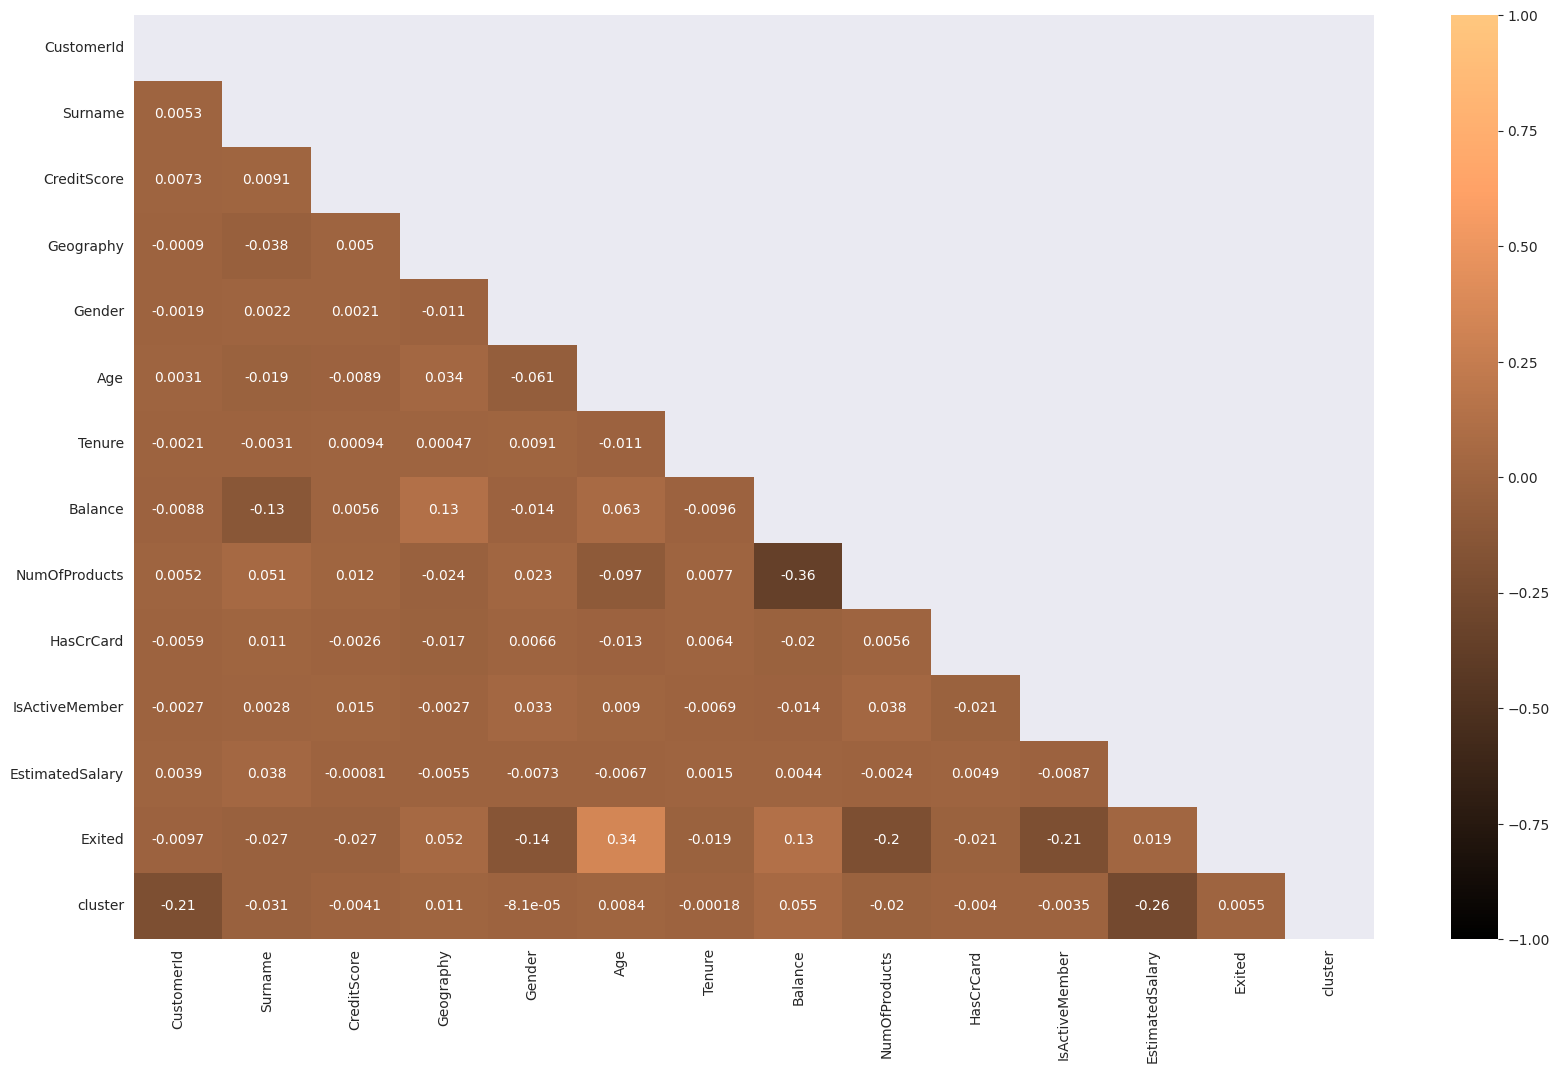

In [7]:
mask = np.triu(np.ones_like(train_data.corr()))

plt.figure(figsize=(20, 12))
sns.heatmap(train_data.corr(), cmap="copper", annot=True, mask=mask, vmin=-1, vmax=1)

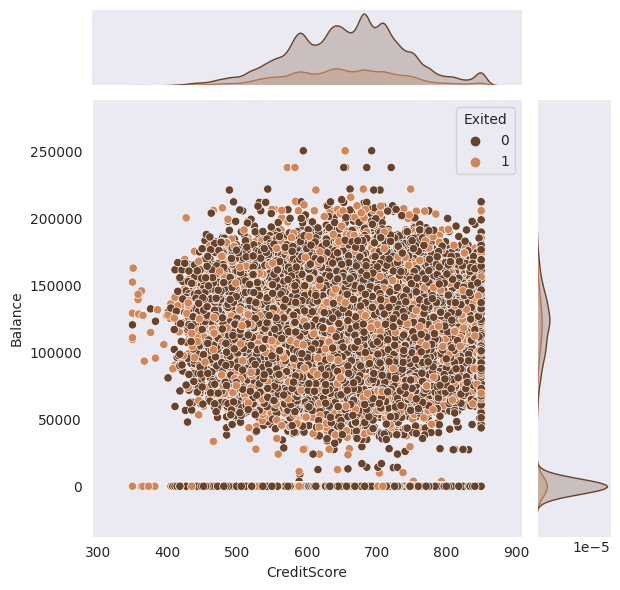

In [8]:
sns.jointplot(data=train_data, x="CreditScore", y="Balance", hue="Exited", palette="copper")

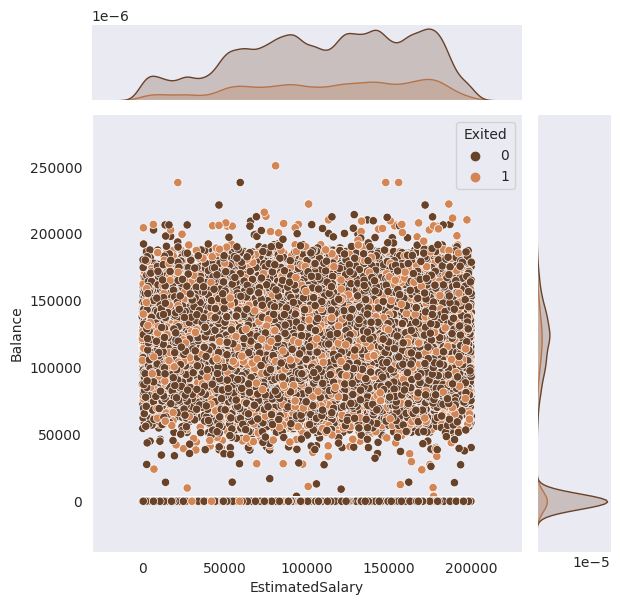

In [9]:
sns.jointplot(data=train_data, x="EstimatedSalary", y="Balance", hue="Exited", palette="copper")

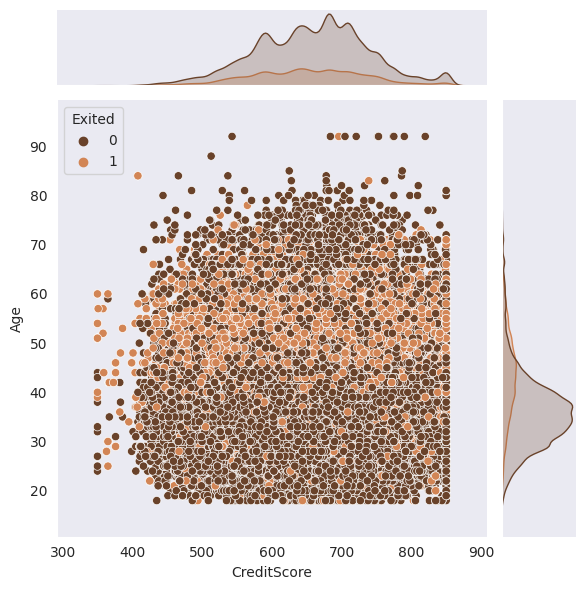

In [10]:
sns.jointplot(data=train_data, x="CreditScore", y="Age", hue="Exited", palette="copper")

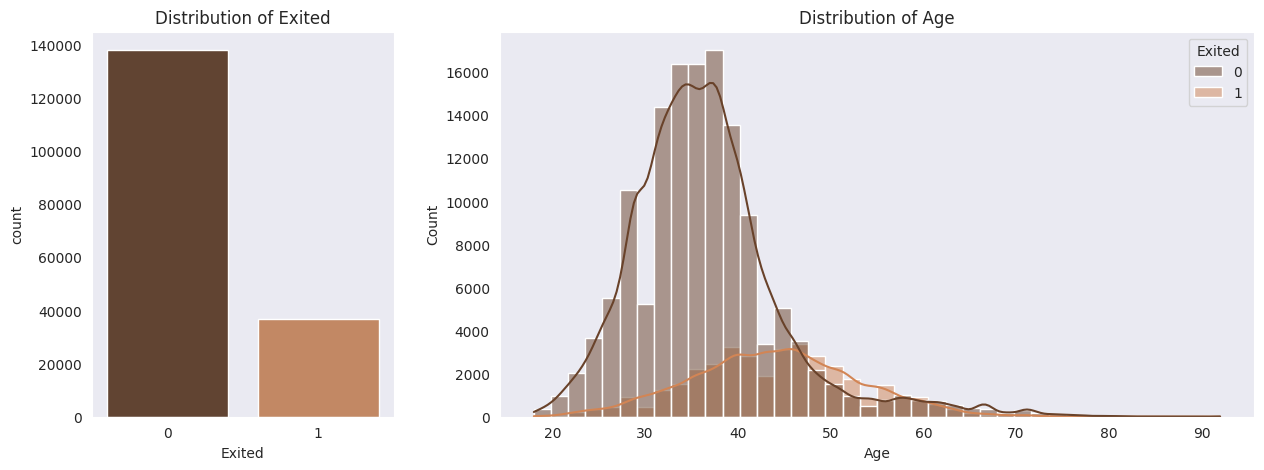

In [11]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 2.5]})

plt.subplot(1, 2, 1)
sns.countplot(data=train_data, x="Exited", palette="copper")
plt.title("Distribution of Exited")

plt.subplot(1, 2, 2)
sns.histplot(data=train_data, x="Age", hue="Exited", bins=40, kde=True, palette="copper")
plt.title("Distribution of Age")

fig.show()

In [12]:
clusts = list(dict(sorted(Counter(clusters_test).items(), key=lambda item:item[0])).values())
clusts.extend(list(dict(sorted(Counter(clusters_test).items(), key=lambda item:item[0])).values()))

clusters = pd.DataFrame()
clusters["clusters_type"] = ["test"] * N_CLUSTERS + ["train"] * N_CLUSTERS
clusters["Cluster Label"] = list(range(0, N_CLUSTERS)) * 2
clusters["No of Items"] = clusts

Text(0.5, 1.0, 'KMeans Clusters Train & Test Summary')

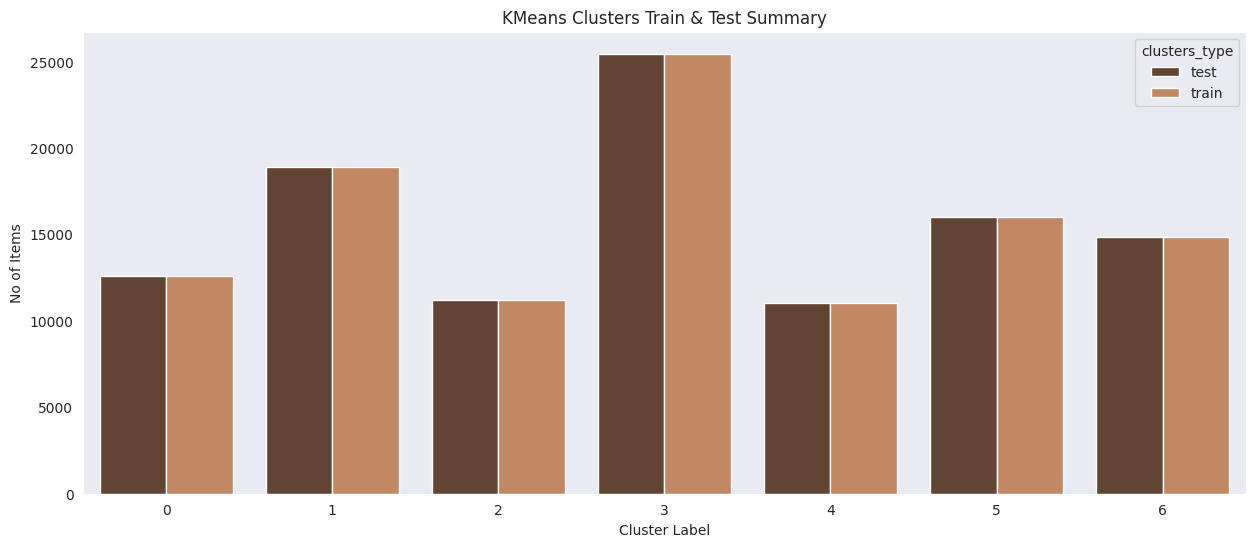

In [13]:
plt.figure(figsize=(15, 6))

sns.barplot(clusters, x="Cluster Label", y="No of Items", hue="clusters_type", palette="copper")
plt.title("KMeans Clusters Train & Test Summary")

In [14]:
clusters["No of Exited"] = 0
clusters["No of Exited"][clusters["clusters_type"]=="train"] = list(dict(sorted(Counter(train_data[train_data["Exited"]==1].cluster).items(), key=lambda item: item[0])).values())
clusters["Ratio of Exited"] = clusters["No of Exited"]/clusters["No of Items"]

<Axes: xlabel='Cluster Label', ylabel='Ratio of Exited'>

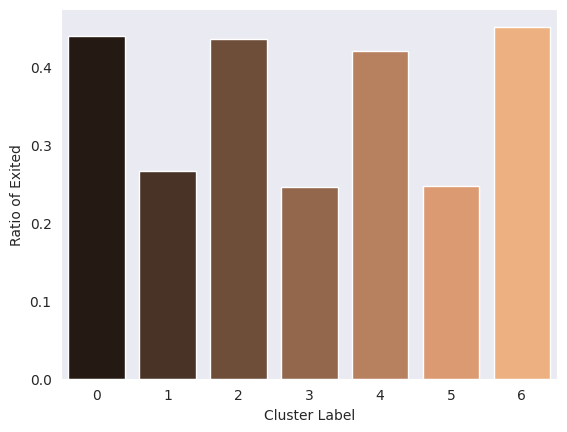

In [15]:
sns.barplot(
    data = clusters.query("clusters_type == 'train'"),
    y = "Ratio of Exited",
    x = "Cluster Label",
    palette="copper"
)

## Model training

In [16]:
seed = np.random.seed(6)

X = train_data.drop("Exited", axis=1)
y = train_data.Exited

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
print(len(X_train), len(X_val))

122522 52510


### Baseline models

In [17]:
lgbmmodel = LGBMClassifier(random_state=seed, device="gpu", verbose=-1)
lgbmmodel.fit(X_train, y_train)
print("\n","-"*25,"Baseline LightGBM", "-" * 25)
print("CV score of LightGBM is ", cross_val_score(lgbmmodel, X, y, cv=4, scoring='roc_auc').mean())
print("ROC AUC over Val Data:", roc_auc_score(lgbmmodel.predict(X_val), y_val))

xgbmodel = XGBClassifier(random_state=seed, tree_method='gpu_hist')
xgbmodel.fit(X_train, y_train)
print("\n","-"*25,"Baseline XGBoost","-"*25)
print("CV score of XGBoost is ", cross_val_score(xgbmodel, X, y, cv=4, scoring='roc_auc').mean())
print("ROC AUC over Val Data:", roc_auc_score(xgbmodel.predict(X_val), y_val))

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.



 ------------------------- Baseline LightGBM -------------------------
CV score of LightGBM is  0.8895154647302521
ROC AUC over Val Data: 0.8157495170369808

 ------------------------- Baseline XGBoost -------------------------
CV score of XGBoost is  0.8870545189425116
ROC AUC over Val Data: 0.8120036194615576


### Auxiliary processing

In [18]:
public_work1 = pd.read_csv("/kaggle/input/pgs41-just-few-lines-of-autogluon/simple_ag.csv")
public_work2 = pd.read_csv("/kaggle/input/ps4e1-advanced-feature-engineering-ensemble/submission.csv")

for i in range(5):
    print(f"> Generating additional data")
    print(f" Initial train size: {len(train_data)} ---> ", end="")
    
    X = train_data.drop("Exited", axis=1)
    y = train_data.Exited
    
    lgbmmodel.fit(X, y)
    xgbmodel.fit(X, y)
    
    more_train = test_data.copy()
    more_train["Exited"] = (lgbmmodel.predict_proba(test_data)[:, 1] + xgbmodel.predict_proba(test_data)[:, 1]) / 2
    more_train["Exited"] = (2 * more_train["Exited"].to_numpy() + public_work1["Exited"].to_numpy() + public_work2["Exited"].to_numpy()) / 4
    more_train = more_train.query("Exited>0.95 | Exited<0.05")
    more_train["Exited"] = round(more_train["Exited"])
    more_train["Exited"] = more_train["Exited"].astype("int64")
    
    train_data = pd.concat([train_data, more_train])
    train_data.drop_duplicates(inplace=True)    
    train_data.reset_index(inplace=True, drop=True)
    train_data = train_data.sample(frac=1)
    
    print(f" Final train size: {len(train_data)}\n")

> Generating additional data
 Initial train size: 175032 --->  Final train size: 218668

> Generating additional data
 Initial train size: 218668 --->  Final train size: 221006

> Generating additional data
 Initial train size: 221006 --->  Final train size: 221757

> Generating additional data
 Initial train size: 221757 --->  Final train size: 222137

> Generating additional data
 Initial train size: 222137 --->  Final train size: 222429



In [19]:
X = train_data.drop("Exited", axis=1)
y = train_data.Exited

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
print(len(X_train), len(X_val))

155700 66729


In [20]:
lgbmmodel = LGBMClassifier(random_state=seed, device="gpu", verbose=-1)
lgbmmodel.fit(X_train, y_train)
print("\n", "-" * 25,"New baseline scores for LightGBM","-" * 25)
print("CV score of LightGBM is ", cross_val_score(lgbmmodel, X, y, cv=4, scoring='roc_auc').mean())
print("ROC AUC over Val Data:", roc_auc_score(lgbmmodel.predict(X_val), y_val))

xgbmodel = XGBClassifier(random_state=seed, tree_method='gpu_hist')
xgbmodel.fit(X_train, y_train)
print("\n", "-" * 25,"New baseline scores for XGBoost", "-" * 25)
print("CV score of XGBoost is ", cross_val_score(xgbmodel, X, y, cv=4, scoring='roc_auc').mean())
print("ROC AUC over Val Data:", roc_auc_score(xgbmodel.predict(X_val), y_val))


 ------------------------- New baseline scores for LightGBM -------------------------
CV score of LightGBM is  0.91654678434885
ROC AUC over Val Data: 0.8362969404935812

 ------------------------- New baseline scores for XGBoost -------------------------
CV score of XGBoost is  0.915255137078185
ROC AUC over Val Data: 0.8305050178600373


### Optuna-tuned LightGBM classifier

In [21]:
lgbm_params = {'max_depth': 41, 'learning_rate': 0.03432850637422446,
               'min_child_weight': 2.9603503357916763, 'min_child_samples': 30,
               'subsample': 0.8782988886358021, 'subsample_freq': 3,
               'colsample_bytree': 0.501275718332705, 'num_leaves': 25}

lgbmmodel = LGBMClassifier(**lgbm_params, n_estimators=1464, random_state=seed, device="gpu", verbose=-1)
lgbmmodel.fit(X_train, y_train)
print("CV score of LightGBM is ", cross_val_score(lgbmmodel, X, y, cv=4, scoring='roc_auc').mean())
print("ROC AUC over Val Data:", roc_auc_score(lgbmmodel.predict(X_val), y_val))

CV score of LightGBM is  0.9180468684779244
ROC AUC over Val Data: 0.8359622221072874


### Optuna-tuned XGBoost classifier

In [22]:
xgb_params = {'max_depth': 6, 'min_child_weight': 2.7526603493948096,
              'learning_rate': 0.015273686530995825, 'subsample': 0.7109136660293711,
              'gamma': 0.2939927860245192, 'colsample_bytree': 0.5015735880252528,
              'colsample_bylevel': 0.6877145513802184, 'colsample_bynode': 0.9449955113410351}

xgbmodel = XGBClassifier(**xgb_params, n_estimators=1670, random_state=seed, tree_method='gpu_hist')
xgbmodel.fit(X_train, y_train)
print("CV score of XGBoost is ", cross_val_score(xgbmodel, X, y, cv=4, scoring='roc_auc').mean())
print("ROC AUC over Val Data:", roc_auc_score(xgbmodel.predict(X_val), y_val))

CV score of XGBoost is  0.9176090538742927
ROC AUC over Val Data: 0.8362666161918493


## Prediction phase

In [23]:
submission = pd.DataFrame()
submission["id"] = test_data.index
submission["Exited"] = 0

In [24]:
splits = 4
repeats = 2
lgbm_auc_score = []
cat_auc_score = []
xgb_auc_score = []
denom = 0

In [ ]:
for i,(tr, val) in enumerate(RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=seed).split(X, y)):
    
    print("-" * 30, f"FOLD {i + 1} / {splits * repeats}","-"*30)
    X_train, X_test, y_train, y_test = X.iloc[tr, :], X.iloc[val, :], y.iloc[tr], y.iloc[val]
    
    print("\n->","LightGBM:")
    lgbmmodel = LGBMClassifier(**lgbm_params,n_estimators=7500,random_state=seed,device="gpu")
    lgbmmodel.fit(X_train,y_train, eval_set=[(X_test,y_test)], eval_names=["valid"],eval_metric=['auc'], callbacks=[lightgbm.early_stopping(stopping_rounds=2000)])
    auc = roc_auc_score(y_test, lgbmmodel.predict_proba(X_test)[:,1])
    lgbm_auc_score.append(auc)
    print(f"\nFold {i+1} ROC_AUC of LightGBM =", auc,"\n")
    submission["Exited"] += lgbmmodel.predict_proba(test_data)[:,1]
    denom+=1
    
    print("\n->","Category:")
    train_dataset = Pool(data=X.iloc[tr,:],label=y.iloc[tr])
    eval_dataset = Pool(data=X.iloc[val,:],label=y.iloc[val])
    
    catmodel = CatBoostClassifier(iterations=7500,verbose=1000, od_type="Iter",eval_metric="AUC", random_seed=seed, early_stopping_rounds=2000)
    catmodel.fit(train_dataset, use_best_model=True, eval_set=eval_dataset)
    auc = roc_auc_score(y.iloc[val], catmodel.predict_proba(X.iloc[val,:])[:,1])
    cat_auc_score.append(auc)
    submission["Exited"] += catmodel.predict_proba(test_data)[:,1]
    denom+=1
    
    print("\n->","XGB:")
    xgbmodel = XGBClassifier(**xgb_params,n_estimators= 7500,random_state=seed, tree_method='gpu_hist',eval_metric="auc")
    xgbmodel.fit(X_train, y_train, eval_set=[(X_test,y_test)],verbose = True)
    auc = roc_auc_score(y_test, xgbmodel.predict_proba(X_test)[:,1])
    xgb_auc_score.append(auc)
    print(f"\nFold {i+1} ROC_AUC of XGB =", auc)
    submission["Exited"] += xgbmodel.predict_proba(test_data)[:,1]
    denom+=1
    
print("\n\n","-" * 50, sep="")
print("CV score of LightGBM is ", np.array(lgbm_auc_score).mean())
print("CV score of Categories is ", np.array(cat_auc_score).mean())
print("CV score of XGBoost is ", np.array(xgb_auc_score).mean())

------------------------------ FOLD 1 / 8 ------------------------------

-> LightGBM:
[LightGBM] [Info] Number of positive: 28752, number of negative: 138069
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 166821, number of used features: 13
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (1.91 MB) transferred to GPU in 0.002885 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172352 -> initscore=-1.569046
[LightGBM] [Info] Start training from score -1.569046
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (1.68 MB) transferred to GPU in 0.002535 secs. 1 sparse feature groups
Training until valid

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (1.68 MB) transferred to GPU in 0.002728 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (1.67 MB) transferred to GPU in 0.002694 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (1.68 MB) transferred to GPU in 0.002700 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (1.68 MB) transferred to GPU in 0.002686 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (1.67 MB) transferred to GPU in 0.003042 secs. 1 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (1.67 MB) transferred to GPU in 0.002731 secs. 1 sparse feature groups
[LightGBM] [Info] Size of hi

# Generate submission

In [30]:
submission["Exited"] = submission["Exited"] / denom

In [31]:
submission["Exited"] = 0.6 * submission["Exited"] + 0.2 * public_work1["Exited"] + 0.2 * public_work2["Exited"]
submission.to_csv("submission.csv", header=True, index=False)

In [32]:
submission

,id,Exited
0,165034,0.005947
1,165035,0.330145
2,165036,0.007676
3,165037,0.090851
4,165038,0.155797
...,...,...
110018,275052,0.013847
110019,275053,0.084906
110020,275054,0.004424
110021,275055,0.070768


In [33]:
print("Successfully saved as CSV file")

Successfully saved as CSV file
